# Predictions exploitation notebook
Load a prediction file and do things with it such as computing the bagged and unbagged MSE or computing stds

In [5]:
import sys, os
sys.path.append(os.path.abspath("../"))
import pickle
import scipy.spatial as sp
from src.predict import *
from src.exploit import *

In [2]:
# Get true labels and lig_to_pdb mapping
ligand_to_pdb = pickle.load(open('../data/post_processing/utils/all_lig_to_pdb.p', 'rb'))
emb = pickle.load(open('../data/ligands/whole_dict_embed_128.p', 'rb'))

In [3]:
# Get predictions
model_name = 'small_siamsplit_aligned_flips'
pred_path = os.path.join('../data/post_processing/predictions/', model_name + '.p')
predictions = pickle.load(open(pred_path, 'rb'))



In [6]:
# reduce them
rearranged = rearrange_pdb_dict(predictions)
reduced = reduce_preds(rearranged)
reduced_averaged = reduce_preds(rearranged, average=True)

In [5]:
print(rearranged['5xem']['85F'])
print('reduced', reduced['5xem']['85F'].size())
print('reduced_averaged',reduced_averaged['5xem']['85F'].size())
print('reduced', reduced['5xem']['85F'][1,:])
print('reduced_averaged',reduced_averaged['5xem']['85F'][1])
np.mean([0.0399, 0.0660, 0.0834, 0.0710, 0.1035, 0.0945, 0.1044, 0.1036])

[tensor([ 0.4588,  0.0399,  0.5468, -0.9963, -0.0185, -0.7659, -0.0181,  0.0159,
         0.3648,  0.0979,  1.0039,  0.3773, -0.4060,  0.0563, -0.0846,  0.1098,
        -0.0854, -0.0497, -0.0124,  0.1424,  0.2953,  0.8848,  0.4139,  0.0064,
        -0.2453,  0.1564, -0.0411,  0.2251, -0.0859, -0.0626,  0.1884, -0.6771,
         0.2211, -0.9233, -0.0757,  0.0995,  0.2750,  0.0917,  0.9436, -0.1329,
        -0.1400, -0.0721,  0.0120, -0.0200, -0.2379, -0.4368, -0.1142,  0.5682,
         0.1818, -0.1389, -0.3986,  0.0696, -0.3769,  0.3851, -0.0695,  0.0297,
        -0.2439,  0.4636,  0.5191, -0.7940, -0.1170, -0.0541,  0.3826, -0.4469,
        -0.0548,  0.4588,  0.0990, -0.0681,  0.2652,  0.1894, -0.0023, -0.0838,
         0.1040,  0.1930,  0.3598, -0.3052, -0.2627, -0.0480, -0.2253, -0.1605,
        -0.1233, -0.2532, -0.2687,  0.0183, -0.3130, -0.0524, -0.4100,  0.7020,
         0.3306,  0.1083, -0.1500, -0.1260, -0.0470,  0.0322, -0.2135,  0.7565,
        -0.2498, -0.0592,  0.1296,  0.5

0.0832875

# COMPUTE MSE 
bagged/non bagged version for each pdb,pocket

In [6]:
def get_accuracy(pred, true):
    counter = 0
    accuracies = list()
    for pdb, lig_dict in pred.items():
        for lig, pred_fingerprint in lig_dict.items():
            # if we have one prediction ie pred comes from the bagged version:
            if len(pred_fingerprint.size()) ==1:
                true = emb[lig]
                pred_ligand = pred_fingerprint.cpu().t().numpy()
                dist = sp.distance.euclidean(pred_ligand, true) ** 2
            elif len(pred_fingerprint.size()) ==2:
                true = emb[lig][np.newaxis,:]
                pred_ligand = pred_fingerprint.cpu().t().numpy()
                dist = sp.distance_matrix(pred_ligand, true) ** 2
            else:
                raise ValueError('Wrong dimension')
            dist/=128
            accuracies.append(dist)
    accuracies = np.stack(accuracies)
    return accuracies



In [7]:
acc1 = get_accuracy(reduced, emb)
acc2 = get_accuracy(reduced_averaged,emb)
print(acc1.shape, acc2.shape)
print(np.mean(acc1), np.mean(acc2))

(4645, 8, 1) (4645,)
0.08855444 0.0851278043811069


In [8]:
# full stuff

def acc(model):
    pred_path = os.path.join('../data/post_processing/predictions/', model + '.p')
    predictions = pickle.load(open(pred_path, 'rb'))    
    
    rearranged = rearrange_pdb_dict(predictions)
    reduced = reduce_preds(rearranged)
    reduced_averaged = reduce_preds(rearranged, average=True)
    
    acc1 = get_accuracy(reduced, emb)
    acc2 = get_accuracy(reduced_averaged,emb)
    
    return np.mean(acc1), np.mean(acc2)
    
def print_res(model):
    no_bag, bag = acc(model)
    print(f'{model} mse of {no_bag} and bagged mse of {bag}')

In [9]:
#print_res('small_siamsplit_aligned_flips_shuffled')
#print_res('small_siamsplit_aligned')
#print_res('small_siamsplit_aligned_flips')
#print_res('small_siamese_aligned_flips')
#print_res('true_small_siamese_aligned')
print_res('baby_siamsplit_aligned_flips')
print_res('small_siamsplit_flips')
print_res('small_siamsplit')                                                                                                                                   

baby_siamsplit_aligned_flips mse of 0.09863390028476715 and bagged mse of 0.0894730903711749
small_siamsplit_flips mse of 0.09532824158668518 and bagged mse of 0.09171549384761672
small_siamsplit mse of 0.10874857008457184 and bagged mse of 0.10874856992919571


# Compute the error per ligand
We want to see if some families are not predicted well by our script

In [7]:
# returns a ligand : error dict
lig_res = {}
for pdb, lig_dict in reduced_averaged.items():
    for lig, pred_fingerprint in lig_dict.items():
        # if we have one prediction:
        if len(pred_fingerprint.size()) ==1:
            true = emb[lig]
            pred_ligand = pred_fingerprint.cpu().t().numpy()
            dist = sp.distance.euclidean(pred_ligand, true) ** 2
            dist/=128
            if lig not in lig_res:
                lig_res[lig] = [dist]
            else : 
                lig_res[lig].append(dist)
        else:
            raise ValueError('Wrong dimension')

In [86]:
lig_res
tot=list()
for li in lig_res.values():
    tot.extend(li)
np.mean(tot)
len(tot)
    

4645

In [9]:
avg_lig_res = {lig : (emb[lig],np.mean(value)) for lig, value in lig_res.items()}
avg_lig_res

In [42]:
tot=list()
for li in avg_lig_res.values():
    tot.append(li[1])
np.mean(tot)

0.1482682748639725

0.1482682748639725
987


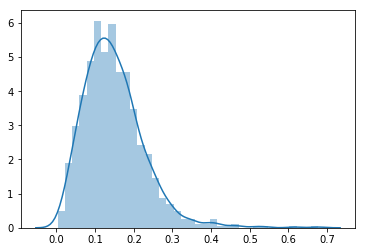

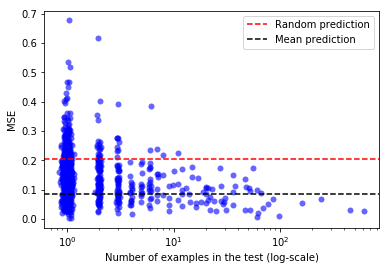

In [85]:
num = [len(value) for lig, value in lig_res.items()]
num = np.array(num) + 0.05*np.random.randn(len(num))
acc = [np.mean(value) for value in lig_res.values()]
print(np.mean(acc))
print(len(num))
sns.distplot(acc)

import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.gca()
ax.plot(num ,acc, 'o', alpha=0.6,c='blue', markeredgecolor='none')
ax.set_xlabel('Number of examples in the test (log-scale)')
ax.set_ylabel('MSE')
ax.axhline(0.206, color='red', linestyle='dashed', label='Random prediction')
ax.axhline(0.085, color='black', linestyle='dashed', label='Mean prediction')
ax.legend()
ax.set_xscale('log')
plt.savefig('num_acc.pdf')

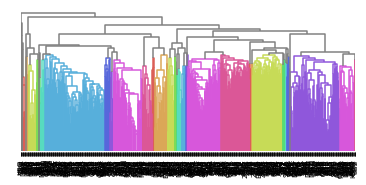

In [13]:
compute_clustering(avg_lig_res)
# We get something super messy, we need to group some of the predictions together

In [14]:
coords = np.array(list(avg_lig_res.values()))
#print(coords[0])
# keep the same order
coords = np.stack(coords[:,0])
coords.shape
#coords[0]

(987, 128)

In [15]:
import scipy.spatial.distance as distance
from scipy.cluster import *

In [16]:
# We get an array T[i] = the cluster of element i
Y = distance.pdist(coords)
Z = hierarchy.linkage(Y, method='average',optimal_ordering=True)
T = hierarchy.fcluster(Z, criterion='maxclust', t=40)
T[:15], T.shape

(array([10, 23,  9, 10,  9, 10, 10, 10, 38, 33, 14, 27, 17, 33,  9],
       dtype=int32), (987,))

In [17]:
# Put all element of the same cluster in one dict category
small = defaultdict(list)
for i, (emb, acc) in enumerate(avg_lig_res.values()):
    small[T[i]].append((emb,acc))
small

defaultdict(list,
            {10: [(array([ 0.12480389, -0.35286972, -0.9934585 , -0.99920905,  0.705729  ,
                      -0.9104931 ,  0.09243727, -0.27292225,  0.93564576, -0.01421067,
                       0.9932008 , -0.07389136, -0.5703586 , -0.17195575, -0.36977777,
                       0.3945255 ,  0.22245099, -0.45849866,  0.54236585, -0.17215875,
                       0.49624294,  0.99651504,  0.02270268,  0.5978968 ,  0.43462315,
                       0.3418785 ,  0.19906735, -0.17128608, -0.6702574 ,  0.01268107,
                      -0.13255432, -0.5072091 , -0.23180567, -0.9494028 , -0.7011509 ,
                      -0.11874799,  0.71814907,  0.5221242 ,  0.993645  , -0.40111643,
                      -0.19059993,  0.32553512,  0.3184671 , -0.16338141, -0.6455567 ,
                       0.17055205,  0.19810897,  0.37165666,  0.0576684 ,  0.0496789 ,
                      -0.8108603 ,  0.26798818, -0.13618815,  0.04652094, -0.48335496,
                     

In [18]:
smaller_lig_res = {}
all_accs = list()
for key,value in small.items():
    embs, accs = zip(*value)
    embs = np.stack(list(embs))
    #print(embs.shape)
    mean_embs = embs.mean(axis=0)
    mean_accs = np.mean(list(accs))
    #all_accs.extend(list(accs))
    #print(mean_accs)
    
    smaller_lig_res[key]=(mean_embs,mean_accs)
smaller_lig_res
    
#np.mean(all_accs)

{10: (array([-0.78347355, -0.14525536, -0.80620533, -0.9395345 ,  0.20529194,
         -0.572183  , -0.05642992,  0.22648701,  0.9695398 , -0.09324006,
          0.9823231 ,  0.16127786, -0.19248934,  0.00869162, -0.15841073,
          0.01399791,  0.12562582, -0.23445916, -0.01087717,  0.06984111,
          0.25480506,  0.996381  ,  0.25766432,  0.3256797 , -0.05385346,
          0.03017115, -0.11177932, -0.16030234, -0.07305939,  0.10190561,
         -0.00545213, -0.6045497 ,  0.23109823,  0.18044175, -0.2674964 ,
         -0.26584005,  0.4740531 ,  0.10233448,  0.5994165 ,  0.06058309,
         -0.2134638 ,  0.01409343,  0.09889105, -0.01053384, -0.36209145,
         -0.23026893, -0.18636969,  0.59800655,  0.0072588 ,  0.01146824,
          0.1579637 , -0.14397804, -0.36427066, -0.00293918, -0.06508677,
         -0.18038926, -0.43400586,  0.9158078 ,  0.38398463, -0.47742   ,
          0.0065585 ,  0.03754986,  0.26649114,  0.43258193, -0.09448505,
          0.0611641 ,  0.39938825,

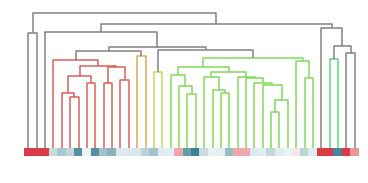

In [94]:
#compute_clustering(smaller_lig_res)
ligand_dict=smaller_lig_res.copy()
L = [l[0] for l in ligand_dict.values()]
DM = pdist(L, metric='euclidean')

# clustering
linked = linkage(DM, method='average', optimal_ordering=True)

# draw
f, axes = plt.subplots(2, 1)
dendrogram(linked,
           ax=axes[0],
           orientation='top',
           distance_sort='descending',
           above_threshold_color='grey',
           show_leaf_counts=True)
# retrieve ordered ligand labels
name_list = list(ligand_dict.keys())
labels = list(axes[0].get_xticklabels())
#labels are indexes in the list given to the linkage algorithm ie the keys list ordering
ligand_inds = [int(l.get_text()) for l in labels]
labels = [name_list[i] for i in ligand_inds]
#labels[i] is thus the correspoding key value of the i-th cluster

axes[0].set_axis_off()
axes[1].set_axis_off()


# heatmap
cmap = sns.diverging_palette(10, 220, center='light', as_cmap=True)
cmap_data = [-ligand_dict[label][1] for label in labels]
#clip values
cmap_data = [max(val, -0.35) for val in cmap_data]
#for l in name_list:
#    cmap_data.append(ligand_dict[l][1])

#cmap_data = cmap_data[::-1]

#print(cmap_data)

g = sns.heatmap([cmap_data], ax=axes[1], annot=False, square=True, cmap=cmap, cbar=False)
# print(list(zip(cmap_data, labels)))

'''
g.set_xticks(np.arange(0.5, len(labels), 2))
g.set_xticklabels(labels[::2])
g.set_yticks([])
g.set_yticklabels([])
axes[1].tick_params(axis='both', which='major', labelsize=7.5)
'''

plt.subplots_adjust(hspace=-0.49)
plt.show()

# Average and std per ligand

In [86]:
lengths = []
selected, means, stds = list(),list(),list()
res = list()
count=0
for lig, results in lig_res.items():
    if max(results)>0.08:
        count +=1
    res.extend(results)
    results = np.array(results)
    length = (len(results))
    lengths.append(length)
    if length>10:
        selected.append(length)
        means.append(np.mean(results))
        stds.append(np.std(results))
np.mean(res)   

0.0851278043811069

0.0851278043811069 0.6769705135411925
4645
375


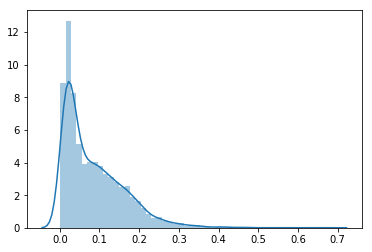

In [87]:

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
res = np.array(res)
print(np.mean(res), np.max(res))

print(len(res))
print(np.sum(res>0.2))
sns.distplot(res)

In [44]:
from scipy.stats import pearsonr
corr, p_value = pearsonr(means,selected)
print(corr)

-0.2875969208135325


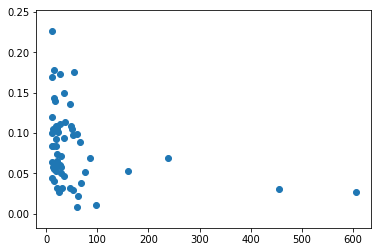

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(selected,means)
plt.show()

Counter({1: 712, 2: 104, 6: 92, 3: 52, 4: 16, 5: 11})


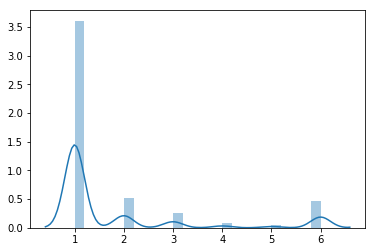

In [52]:
dist = []
from collections import Counter
count = Counter()
for lig, li in ligand_to_pdb.items():
    length = len(li)
    if length > 6 :
        length = 6
    dist.append(length)
    count[length]+=1
print(count)
sns.distplot(dist)

# Get the per dimension std and mse

In [90]:
reduced_averaged


{'5xem': {'85F': tensor([ 2.8376e-01,  8.3288e-02,  4.6829e-01, -9.4196e-01, -4.0794e-02,
          -6.2046e-01, -1.2164e-03,  7.0711e-02,  5.6442e-01,  1.2401e-01,
           9.8478e-01,  3.1342e-01, -3.9803e-01,  6.1750e-03, -3.6292e-02,
           3.2717e-02, -1.0192e-01, -3.2681e-02, -1.2544e-02,  1.2274e-01,
           3.1144e-01,  9.4364e-01,  3.2170e-01,  2.8886e-02, -2.5853e-01,
           1.3046e-01, -2.5860e-02,  1.7700e-01, -5.6074e-02, -1.4241e-02,
           1.6201e-01, -6.3158e-01,  1.8337e-01, -8.4229e-01, -9.1306e-02,
           5.2662e-02,  2.7480e-01,  6.2807e-02,  8.7429e-01, -1.1384e-01,
          -1.2299e-01, -6.0679e-02, -5.2971e-04,  1.9121e-02, -2.3672e-01,
          -3.8838e-01, -1.5808e-01,  5.4157e-01,  1.2307e-01, -1.1482e-01,
          -3.1845e-01,  2.3218e-02, -3.4985e-01,  3.4076e-01, -3.4651e-02,
          -3.5501e-03, -2.2395e-01,  5.7632e-01,  4.8528e-01, -6.6698e-01,
          -8.1080e-02,  3.3535e-02,  3.3182e-01, -2.2142e-01, -4.9727e-02,
          

In [15]:
mses = list()
for pdb, lig_dict in reduced_averaged.items():
    for lig, pred_fingerprint in lig_dict.items():
        # if we have one prediction:
        if len(pred_fingerprint.size()) ==1:
            true = emb[lig]
            pred_ligand = pred_fingerprint.cpu().t().numpy()
            dist = (pred_ligand - true) ** 2
            mses.append(dist)

mses = np.stack(mses)
mses_dim = np.mean(mses, axis=0)
mses_dim.mean()

(4645, 128)

In [23]:
stacked = np.stack(list(emb.values()))
print(stacked.shape)
vars = np.std(stacked,axis=0)**2
vars

(3365, 128)


array([0.6643489 , 0.12252839, 0.6942392 , 0.44372165, 0.144368  ,
       0.67904603, 0.11867354, 0.11829431, 0.7494502 , 0.13935143,
       0.54495656, 0.1271185 , 0.11916936, 0.11919306, 0.11217222,
       0.12298357, 0.11697389, 0.1253174 , 0.11858323, 0.10792173,
       0.09953436, 0.6196898 , 0.13351813, 0.18706556, 0.10834549,
       0.12411848, 0.1120758 , 0.12681788, 0.17512721, 0.15515617,
       0.11074694, 0.15786548, 0.11785367, 0.31989202, 0.11617785,
       0.12037684, 0.13412488, 0.12619683, 0.23709582, 0.09753661,
       0.11652547, 0.12533092, 0.13427487, 0.1410676 , 0.12767552,
       0.14845969, 0.111573  , 0.16315536, 0.17166518, 0.09957965,
       0.1555499 , 0.1337364 , 0.09826595, 0.12751116, 0.12937127,
       0.12329117, 0.16513945, 0.6807045 , 0.1597182 , 0.52327824,
       0.11845369, 0.12231156, 0.1206744 , 0.59552693, 0.11855639,
       0.13506702, 0.18461855, 0.1324647 , 0.22478527, 0.13346817,
       0.14924845, 0.13185045, 0.1306311 , 0.11530982, 0.15452

In [22]:
preds_dim = list()
for pdb, lig_dict in reduced_averaged.items():
    for lig, pred_fingerprint in lig_dict.items():
        # if we have one prediction:
        if len(pred_fingerprint.size()) ==1:
            pred_ligand = pred_fingerprint.cpu().t().numpy()
            preds_dim.append(pred_ligand)

preds_dim = np.stack(preds_dim)
preds_dim.shape

(4645, 128)

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
for i in range (20):
    dimi = stacked[i,:]
    predi = preds_dim[i,:]
    print(np.std(dimi)**2, mses_dim[i])
    sns.distplot(dimi)
    sns.distplot(predi)
    plt.show()

0.2275941392149372 0.18956086


/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


FileNotFoundError: [Errno 2] No such file or directory: 'latex': 'latex'

<Figure size 432x288 with 1 Axes>

0.23270875372827593 0.055900294


FileNotFoundError: [Errno 2] No such file or directory: 'latex': 'latex'

<Figure size 432x288 with 1 Axes>

0.1960389428588769 0.48241135


FileNotFoundError: [Errno 2] No such file or directory: 'latex': 'latex'

<Figure size 432x288 with 1 Axes>

0.29435031332184636 0.08902267


FileNotFoundError: [Errno 2] No such file or directory: 'latex': 'latex'

<Figure size 432x288 with 1 Axes>

0.23811457014986193 0.04840082


FileNotFoundError: [Errno 2] No such file or directory: 'latex': 'latex'

<Figure size 432x288 with 1 Axes>

0.29878405350531523 0.17776416


FileNotFoundError: [Errno 2] No such file or directory: 'latex': 'latex'

<Figure size 432x288 with 1 Axes>

0.2549715397721144 0.06310003


FileNotFoundError: [Errno 2] No such file or directory: 'latex': 'latex'

<Figure size 432x288 with 1 Axes>

0.3342469858694699 0.08824085


FileNotFoundError: [Errno 2] No such file or directory: 'latex': 'latex'

<Figure size 432x288 with 1 Axes>

0.2332185108615228 0.10558838


FileNotFoundError: [Errno 2] No such file or directory: 'latex': 'latex'

<Figure size 432x288 with 1 Axes>

0.26697953630902305 0.0777224


FileNotFoundError: [Errno 2] No such file or directory: 'latex': 'latex'

<Figure size 432x288 with 1 Axes>

0.21622167739952491 0.07604445


FileNotFoundError: [Errno 2] No such file or directory: 'latex': 'latex'

<Figure size 432x288 with 1 Axes>

0.19380860356364238 0.07659125


FileNotFoundError: [Errno 2] No such file or directory: 'latex': 'latex'

<Figure size 432x288 with 1 Axes>

0.26954434444179753 0.061064214


FileNotFoundError: [Errno 2] No such file or directory: 'latex': 'latex'

<Figure size 432x288 with 1 Axes>

0.22196823539349797 0.050812107


FileNotFoundError: [Errno 2] No such file or directory: 'latex': 'latex'

<Figure size 432x288 with 1 Axes>

0.233569729902535 0.059966113


FileNotFoundError: [Errno 2] No such file or directory: 'latex': 'latex'

<Figure size 432x288 with 1 Axes>

0.2084084343192396 0.061228227


FileNotFoundError: [Errno 2] No such file or directory: 'latex': 'latex'

<Figure size 432x288 with 1 Axes>

0.22675561121332155 0.05751655


FileNotFoundError: [Errno 2] No such file or directory: 'latex': 'latex'

<Figure size 432x288 with 1 Axes>

0.316517504396959 0.04329496


FileNotFoundError: [Errno 2] No such file or directory: 'latex': 'latex'

<Figure size 432x288 with 1 Axes>

0.20882646213875944 0.060269758


FileNotFoundError: [Errno 2] No such file or directory: 'latex': 'latex'

<Figure size 432x288 with 1 Axes>

0.1956930340377463 0.064078435


FileNotFoundError: [Errno 2] No such file or directory: 'latex': 'latex'

<Figure size 432x288 with 1 Axes>

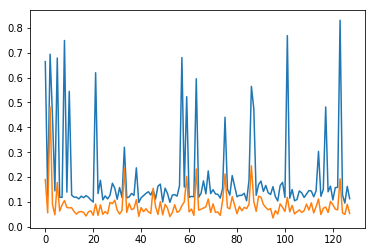

In [119]:
plt.plot(vars)
plt.plot(mses_dim)

In [127]:
np.sum(np.log(stds/mses_dim))

97.10319

In [128]:
print('number of samples needed', np.exp(97.1))
print('average number of bins needed', np.mean(stds/mses_dim))

number of samples needed 1.4790886103154883e+42
average number of bins needed 2.3216767


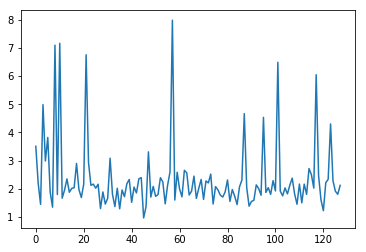

In [135]:
plt.plot(vars/(mses_dim))

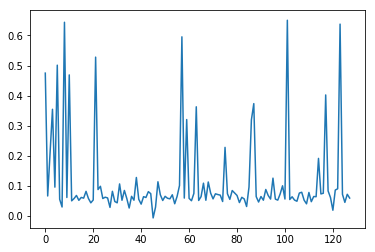

In [133]:
plt.plot(vars-mses_dim)

In [3]:
embs = np.array(list(emb.values()))

In [4]:
DM = sp.distance_matrix(embs,embs)
DM.shape

(3365, 3365)

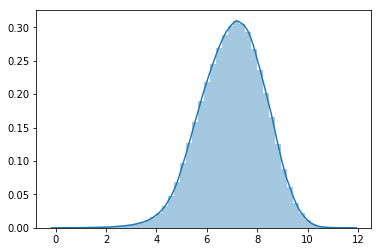

In [14]:
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
sns.distplot(DM.flatten())

In [9]:
np.sum((DM[0]<4))

60

In [10]:
(DM[0]<4)

array([ True, False, False, ..., False, False, False])